In [1]:
import sys
sys.path.insert(0, '../../vector_field/velvet_ecosystem/velvet/')
import velvet as vt

import scvelo as scv
import scanpy as sc
import scFates as scf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.sparse import issparse
from tqdm import tqdm, trange

from cellrank.tl.kernels import PseudotimeKernel


/camp/home/maizelr/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /camp/home/maizelr/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/camp/home/maizelr/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_exp

In [2]:
adata0 = vt.pp.read("../data/celltyped_adata.h5ad")
adata0 = adata0[adata0.obs.cell_annotation!='other']

In [3]:
def process_for_pseudotime(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(total=X, connectivities=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

def run_tree(
    adata, 
    layer,
    n_nodes=200,
    seed=1,
    ppt_lambda=50,
    ppt_sigma=1.5,
    ndims_rep=50,
    figsize=(9,4),
    color='cell_annotation'
    ):
    scf.tl.tree(adata, method="ppt",Nodes=n_nodes, use_rep="X_pca_smooth",
                device="cpu",seed=seed,ppt_lambda=ppt_lambda,ppt_sigma=ppt_sigma,
                ppt_nsteps=300, ndims_rep=ndims_rep)
    fig = plt.figure(figsize=figsize)
    ax1, ax2 = fig.subplots(1,2)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax1, dimensions=[0,1], show=False, forks=False)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax2, dimensions=[0,2], show=False, forks=False)
    print(f"Tips: {adata.uns['graph']['tips']}")
    print()
    print(f"Forks: {adata.uns['graph']['forks']}")
    plt.show()

def run_pseudotime(adata, root, n_maps=10):    
    scf.tl.root(
        adata,
        root
    )

    scf.tl.pseudotime(
        adata,
        n_jobs=20,
        n_map=n_maps,
        seed=42
    )
    adata.obs['seg'] = adata.obs['seg'].astype('category')
    scf.pl.trajectory(adata, basis='pca', color_cells='seg')

def get_cell_pseudotime_vector(adata, cell_idx, basis='pca', ndim=50):
    idx = adata.uns['graph']['pp_info'].sort_values('time').PP.values
    points = adata.uns['graph']['F'].T[idx]
    segs = adata.uns['graph']['pp_info'].seg.values[idx]
    
    
    cell = adata[cell_idx]
    cell_rep = cell.obsm[f'X_{basis}'][:,:ndim]
    cell_seg = cell.obs.seg.values[0]
    
    seg_points = points[segs==cell_seg][:,:ndim]
    best = np.sqrt(np.sum((cell_rep - seg_points)**2, axis=1)).argmin()
    try:
        vector = seg_points[best+1] - seg_points[best]
    except IndexError:
        vector = np.zeros_like(seg_points[best])
    return vector

def calculate_pseudotime_vectorfield(adata, ndim=50, basis='pca'):
    vf = np.zeros_like(adata.obsm[f"X_{basis}"][:,:ndim])
    for i in trange(adata.shape[0]):
        vf[i,:] = get_cell_pseudotime_vector(adata, cell_idx=i, basis=basis, ndim=ndim)
    adata.obsm['velocity_pst'] = vf
    adata.obsm['X_pst'] = adata.obsm[f"X_{basis}"][:,:ndim]
    
def viz(adata, genes):
    """
    we don't want to keep the log transformed data or PCA, but want to viz
    """
    copy = adata.copy()    
    sc.pp.log1p(copy)
    sc.pp.pca(copy)
    sc.pl.pca(copy, color=['cell_annotation','timepoint','rep'])
    
def calculate_cellrank_vectorfield(adata, ndim=50, basis='pca'):
    cnx = vt.pp.connectivities(total=adata.layers['total'], n_neighbors=30)
    adata.obsp['neighbors_connectivities'] = cnx
    pk = PseudotimeKernel(adata, time_key='t')
    pk.compute_transition_matrix()
    pk.compute_projection(basis='pca', key_added='velocity_cr')
    adata.obsm['X_cr_pca'] = adata.obsm[f"X_{basis}"][:,:ndim]

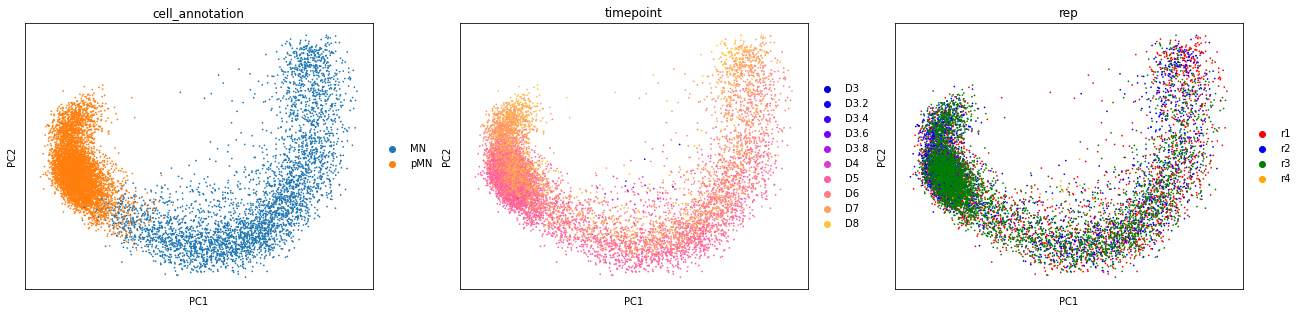

In [4]:
### 1. MN

types = ['MN', 'pMN']

adata = adata0[[ct in types for ct in adata0.obs.cell_annotation]]

genes = vt.pp.select_genes(
    adata[adata.obs.rep!='r4'], 
    n_variable_genes=2000, 
    stratify_obs='rep')

adata = vt.pp.size_normalize(
    adata, 
    genes=genes, 
    total_layer='total', 
    new_layer='new',
    unsparsify=True
)

adata = process_for_pseudotime(adata, 'total')

sc.pl.pca(adata, color=['cell_annotation','timepoint','rep'])

inferring a principal tree --> parameters used 
    100 principal points, sigma = 3.2, lambda = 100, metric = euclidean
    fitting:  10%|▉         | 29/300 [00:01<00:16, 16.91it/s]
    converged
    finished (0:00:01) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.
Tips: [37 44 62]

Forks: [24]


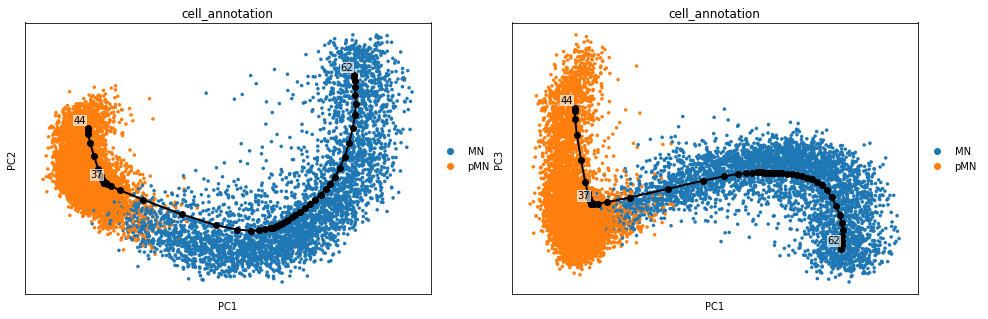

In [5]:
run_tree(
    adata, 
    'total',
    n_nodes=100,
    seed=0,
    ppt_lambda=100,
    ppt_sigma=3.2,
    ndims_rep=50,
    figsize=(16,5)
)

node 37 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]
    finished (0:00:52) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


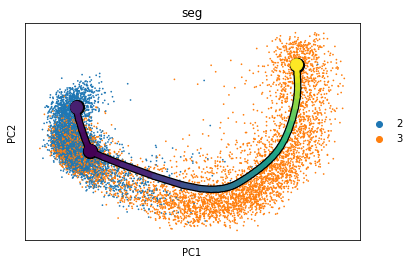

In [6]:
run_pseudotime(adata, root=37)

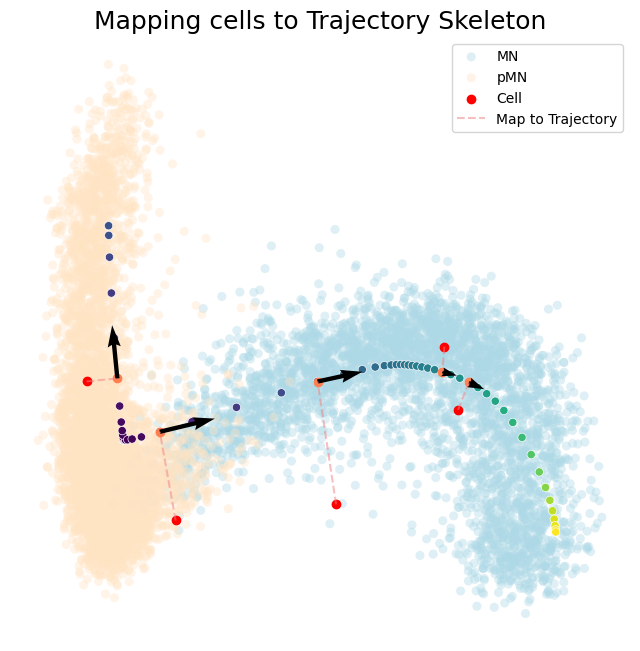

In [112]:
idx = adata.uns['graph']['pp_info'].sort_values('time').PP.values
points = adata.uns['graph']['F'].T[idx]
time = adata.uns['graph']['pp_info'].sort_values('time').time.values
segs = adata.uns['graph']['pp_info'].seg.values[idx]

adata2 = adata[idx,:]

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.subplots()
sc.pl.scatter(adata, basis='pca', frameon=False, title='', components='1,3',
              ax=ax, color='cell_annotation', size=170, alpha=0.4,show=False, 
              palette={'lightblue':'pMN','bisque':'MN'})
sns.scatterplot(points[:,0], points[:,2], hue=time, ax=ax, palette='viridis', legend=False)
ax.set_title('Mapping cells to Trajectory Skeleton', fontsize=18)
for i, a in enumerate([50, 78, 43, 63, 2]):
    try:
        cell = adata2[a]
        cell_rep = cell.obsm['X_pca'][:,[0,2]]
        cell_seg = cell.obs.seg.values[0]

        seg_points = points[segs==cell_seg][:,[0,2]]
        best = np.sqrt(np.sum((cell_rep - seg_points)**2, axis=1)).argmin()

        ax.scatter(seg_points[best,0], seg_points[best,1], c='coral')

        if i==0:
            ax.scatter(cell_rep[:,0], cell_rep[:,1], c='red', label='Cell')
        else:
            ax.scatter(cell_rep[:,0], cell_rep[:,1], c='red')
        if i==0:
            ax.plot([cell_rep[:,0][0],seg_points[best,0]], [cell_rep[:,1][0],seg_points[best,1]],
                    color='lightcoral', alpha=0.5, linestyle='--', label='Map to Trajectory')
        else:
            ax.plot([cell_rep[:,0][0],seg_points[best,0]], [cell_rep[:,1][0],seg_points[best,1]],
                    color='lightcoral', alpha=0.5, linestyle='--')
        ax.quiver(
            seg_points[best,0], 
            seg_points[best,1], 
            seg_points[best+1,0] - seg_points[best,0], 
            seg_points[best+1,1] - seg_points[best,1],
            width = .007, 
            headlength = 5,
            scale=3,
            scale_units='inches',
        )
    except IndexError:
        pass
plt.legend()
plt.show()

In [113]:
calculate_pseudotime_vectorfield(adata)

100%|██████████| 10180/10180 [00:27<00:00, 367.08it/s]


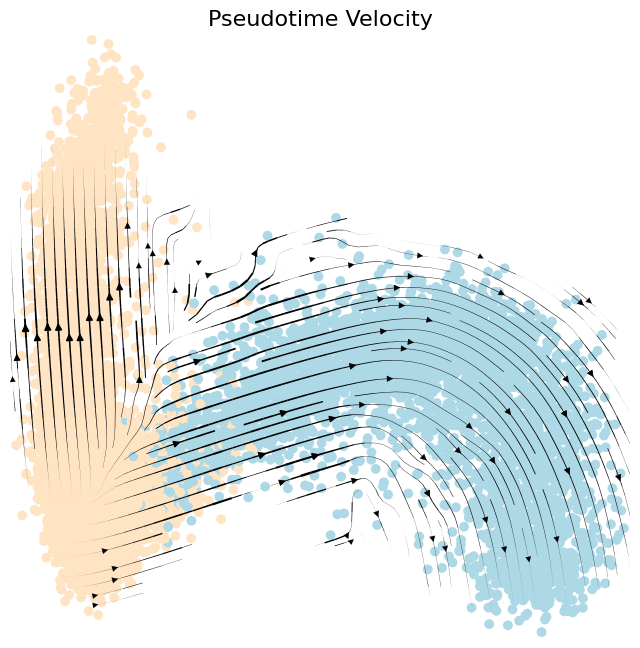

In [135]:
fig = plt.figure(figsize=(8,8), dpi=100)

ax = fig.subplots()

adata.uns["velocity_params"] = {'embeddings':'pst'}
scv.pl.velocity_embedding_stream(
    adata, 
    basis='pst', 
    title="Pseudotime Velocity",
    color='cell_annotation', 
    show=False,
    ax=ax, alpha=1,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,3'
)
plt.show()

In [117]:
cnx = vt.pp.connectivities(total=adata.layers['total'], n_neighbors=30)
adata.obsp['neighbors_connectivities'] = cnx

pk = PseudotimeKernel(adata, time_key='t')

pk.compute_transition_matrix()

pk.compute_projection(basis='pca', key_added='velocity_cr')

adata.obsm['X_cr_pca'] = adata.obsm[f"X_pca"][:,:50]

  0%|          | 0/10180 [00:00<?, ?cell/s]

In [121]:
adata.uns['velocity_graph'] = pk.transition_matrix

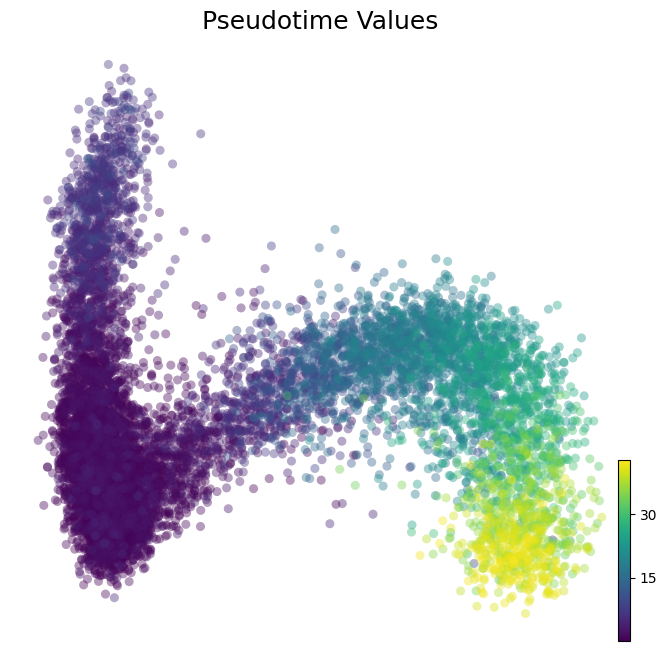

In [132]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.subplots()
scv.pl.scatter(adata, basis='pca', frameon=False, title='', components='1,3',
              ax=ax, color='t', size=170, alpha=0.4, show=False)
ax.set_title('Pseudotime Values', fontsize=18)
plt.show()

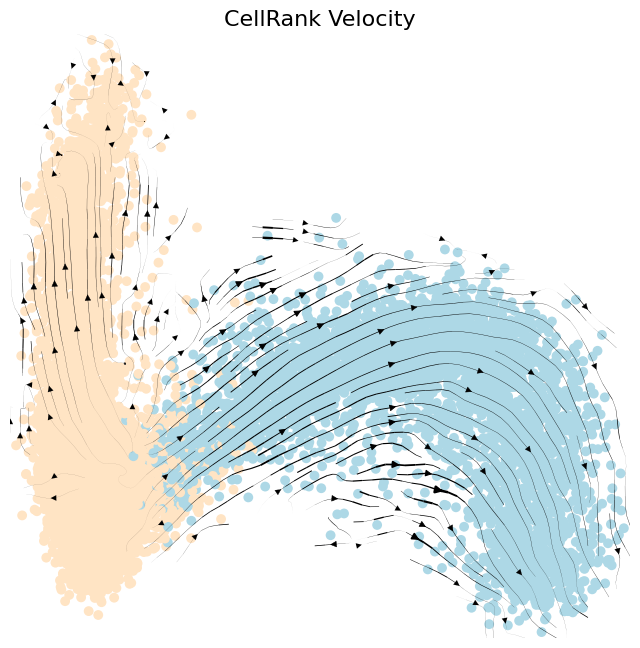

In [136]:
fig = plt.figure(figsize=(8,8), dpi=100)

ax = fig.subplots()

adata.uns["velocity_params"] = {'embeddings':'cr_pca'}
scv.pl.velocity_embedding_stream(
    adata, 
    basis='cr_pca', 
    title="CellRank Velocity",
    color='cell_annotation', 
    show=False,
    ax=ax, alpha=1,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,3'
)
plt.show()